In [1]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

/users/4/rozan012/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


import phik
from phik.report import plot_correlation_matrix
from phik import report
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows

/users/4/rozan012/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Data Preprocessing

In [3]:
df = pd.read_csv('../data_v02/dataset.csv')
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,ARVI_rol_30,ARVI_rol_7,ARVI_min,ARVI_max,ARVI_std,doy,lat,lon,IGBP,LE
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,2.932151,5.971087,-44.711864,27.949356,11.366360,144,46.7305,-91.2329,DBF,19.2224
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,2.905350,5.918134,-44.711864,27.949356,11.363106,145,46.7305,-91.2329,DBF,24.2024
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,2.903013,5.913157,-44.711864,27.949356,11.363742,146,46.7305,-91.2329,DBF,19.4017
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,2.855912,5.816337,-44.711864,27.949356,11.352651,147,46.7305,-91.2329,DBF,23.7468
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,2.853934,5.812325,-44.711864,27.949356,11.353173,148,46.7305,-91.2329,DBF,42.2603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,3.391581,2.035396,-4.139233,21.158958,5.145233,254,46.6347,-91.0987,DBF,55.7628
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,4.053568,5.828223,-4.139233,23.634561,6.333234,256,46.6347,-91.0987,DBF,31.6040
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,4.022291,5.774212,-4.139233,23.634561,6.331761,257,46.6347,-91.0987,DBF,54.2463
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,4.021106,5.769007,-4.139233,23.634561,6.332555,258,46.6347,-91.0987,DBF,44.2428


In [4]:
class Dataset():
    def __init__(self, X, Y, x_scaler=None, y_scaler=None, fit_scaler=False):
        if fit_scaler:
            self.x_scaler = MinMaxScaler()  
            self.y_scaler = MinMaxScaler()  
            X = self.x_scaler.fit_transform(X) 
            Y = self.y_scaler.fit_transform(Y.reshape(-1, 1)) 
        elif x_scaler is not None:
            X = x_scaler.transform(X)  
            Y = y_scaler.transform(Y.reshape(-1, 1)) 
            
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32).to(device)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LE'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

In [8]:
BATCH_SIZE = 512
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
one_hot = pd.get_dummies(X_train.IGBP)
X_train_ann = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
one_hot = pd.get_dummies(X_test.IGBP)
X_test_ann = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)

In [10]:
train_dataset = Dataset(X_train_ann, y_train.values, fit_scaler=True)
x_scaler = train_dataset.x_scaler 
y_scaler = train_dataset.y_scaler 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False)
test_loader = DataLoader(Dataset(X_test_ann.values, y_test.values,
                                 x_scaler=x_scaler, y_scaler=y_scaler), batch_size=BATCH_SIZE, drop_last=False)

/users/4/rozan012/.local/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


# ANN

### LOGS:
**Stratified by IGBP:**

R2: 0.982	RMSE: 5.351	MAE: 1.437

In [14]:
class ANN(nn.Module):
    def __init__(self, INPUT_SIZE, n1, n2, dropout=0.3):
        super().__init__()
	
        self.net = nn.Sequential()
        self.net.add_module('Linear_1', nn.Linear(INPUT_SIZE, n1))
        self.net.add_module('ReLU_1', nn.Tanh()) #Sigmoid
        self.net.add_module('Drop_1', nn.Dropout(dropout))
        
        self.net.add_module('Linear_2', torch.nn.Linear(n1, n2))
        self.net.add_module('Norm', nn.BatchNorm1d(n2))
        self.net.add_module('ReLU_2', nn.Tanh())
        self.net.add_module('Drop_2', nn.Dropout(dropout))
        self.net.add_module('Linear_3',torch.nn.Linear(n2, 1))

    def forward(self, y):
        return self.net(y)

In [22]:
num_epoch = 200
feature_num = X_test_ann.values.shape[1]
n1 = 400
n2 = 100
dropout=0.3

In [15]:
model = ANN(feature_num, n1,n2, dropout).to(device).to(torch.float32)

In [16]:
model.load_state_dict(torch.load('../models/ANN.pth'))

<ipython-input-16-0fe9860f9e94>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/ANN.pth'))


<All keys matched successfully>

In [23]:
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [24]:
best = -np.inf
t0 = time.time()
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, y in train_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)
        pred = model(x)
        error = criteria(pred, y)

        optimizer.zero_grad()
        error.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        test_preds = []
        test_true = []
        test_x = []
        test_idx = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(torch.float32), y.to(torch.float32)
                preds = model(x)
                preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
                y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
                test_preds.append(torch.tensor(preds))
                test_true.append(torch.tensor(y_scaled))

        test_preds = torch.cat(test_preds).squeeze()
        test_true = torch.cat(test_true).squeeze()
        
        test_loss = criteria(test_preds, test_true).item()
        r2 = r2_score(test_true.numpy(), test_preds.numpy())
        mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
        #writer.add_scalar("Loss/test", test_loss, epoch)
        #writer.add_scalar("R2/test", r2, epoch)
        
        best_old = best
        best = min(test_loss, best)
        if abs(best) > best_old:
            torch.save(model.state_dict(), f'../models/ANN.pth') #0.6532
            #writer.add_text("Checkpoint", "Saved model at epoch {}".format(epoch))
        print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')
#writer.close()

Test RMSE: 11.284		Test R2: 0.9218		 Test MAE: 7.5042
Test RMSE: 11.252		Test R2: 0.9222		 Test MAE: 7.4535
Test RMSE: 11.254		Test R2: 0.9222		 Test MAE: 7.4624
Test RMSE: 11.283		Test R2: 0.9218		 Test MAE: 7.4864
Test RMSE: 11.286		Test R2: 0.9218		 Test MAE: 7.4666
Test RMSE: 11.233		Test R2: 0.9225		 Test MAE: 7.4460
Test RMSE: 11.243		Test R2: 0.9224		 Test MAE: 7.4458
Test RMSE: 11.245		Test R2: 0.9223		 Test MAE: 7.4604
Test RMSE: 11.252		Test R2: 0.9222		 Test MAE: 7.4622
Test RMSE: 11.261		Test R2: 0.9221		 Test MAE: 7.4626
Test RMSE: 11.257		Test R2: 0.9222		 Test MAE: 7.4634
Test RMSE: 11.271		Test R2: 0.9220		 Test MAE: 7.4728
Test RMSE: 11.260		Test R2: 0.9221		 Test MAE: 7.4524
Test RMSE: 11.230		Test R2: 0.9225		 Test MAE: 7.4299
Test RMSE: 11.266		Test R2: 0.9220		 Test MAE: 7.4694
Test RMSE: 11.237		Test R2: 0.9224		 Test MAE: 7.4557
Test RMSE: 11.278		Test R2: 0.9219		 Test MAE: 7.4593
Test RMSE: 11.237		Test R2: 0.9224		 Test MAE: 7.4590
Test RMSE: 11.230		Test R2: 

In [28]:
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)
        preds = model(x)
        preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
        y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
        test_preds.append(torch.tensor(preds))
        test_true.append(torch.tensor(y_scaled))

test_preds = torch.cat(test_preds).squeeze()
test_true = torch.cat(test_true).squeeze()

test_loss = criteria(test_preds, test_true).item()
r2 = r2_score(test_true.numpy(), test_preds.numpy())
mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')

preds = pd.DataFrame({"LE":test_preds.numpy()})
Y_test = pd.DataFrame({"LE":np.array(y_test)})
resid = pd.DataFrame({"LE":preds.LE - Y_test.LE})

Test RMSE: 11.230		Test R2: 0.9225		 Test MAE: 7.4498


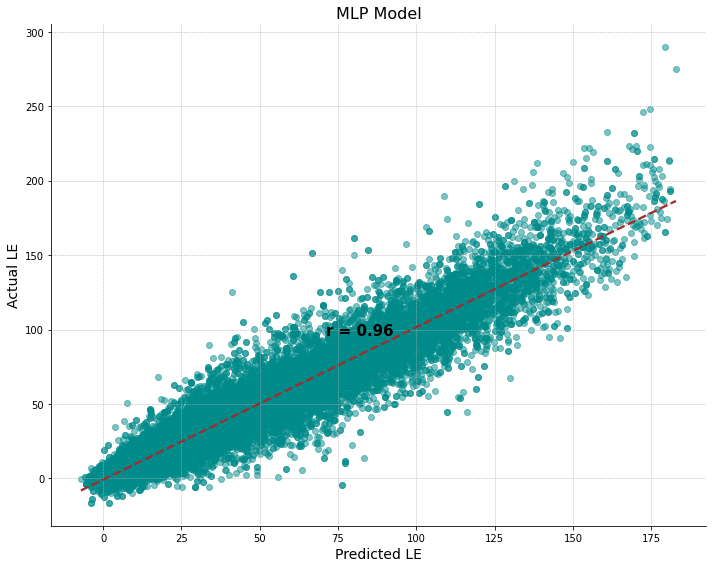

In [27]:
plt.figure(figsize=(10, 8))



ax = sns.regplot(
    x=preds['LE'],
    y=Y_test['LE'],
    scatter_kws={'alpha':0.5, 'color':'darkcyan'},
    line_kws={'color':'brown', 'ls': '--'}
)

corr = np.corrcoef(preds['LE'], Y_test['LE'])[0, 1]
plt.text(0.42, 0.38, f'r = {corr:.2f}', transform=ax.transAxes, fontsize=15, fontweight='bold')

plt.title('MLP Model', fontsize=16)
plt.xlabel('Predicted LE', fontsize=14)
plt.ylabel('Actual LE', fontsize=14)

ax.grid(True, lw=0.5, ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()